In [321]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import geopandas as gpd
import contextily as cx
import matplotlib.ticker as mticker

# Import the data

Now, the phone data:

In [322]:
file_name = '2024-10-09_10-38-46'

In [323]:
acc = pd.read_csv('./../../Data_phone/final/' + file_name + '/Accelerometer.csv',sep=',',header=0,names=['time','seconds_elapsed','acc_z','acc_y','acc_x'])
gyr = pd.read_csv('./../../Data_phone/final/' + file_name + '/Gyroscope.csv',sep=',',header=0,names=['time','seconds_elapsed','gyr_z','gyr_y','gyr_x'])
#mag = pd.read_csv('./../../Data_phone/pali-otthon/Magnetometer.csv',sep=',',header=0,names=['time','seconds_elapsed','mag_z','mag_y','mag_x'])
loc = pd.read_csv('./../../Data_phone/final/' + file_name + '/Location.csv',sep=',')

df = pd.concat([acc, gyr[['gyr_z','gyr_y','gyr_x']]], axis=1) #Concat the vibration data """, mag[['mag_z','mag_y','mag_x']]"""

In [324]:
loc = loc.rename(columns={'latitude':'lat','longitude':'lon'})

In [325]:
df

,time,seconds_elapsed,acc_z,acc_y,acc_x,gyr_z,gyr_y,gyr_x
0,1728470326510681900,0.021682,-0.160272,-0.654907,1.204232,0.268744,0.022450,-0.001444
1,1728470326520741600,0.031742,0.216822,-0.860115,1.101253,0.268238,0.003201,0.008170
2,1728470326530802700,0.041803,0.221510,-0.980948,0.998023,0.268991,0.051419,-0.020873
3,1728470326540863700,0.051864,0.609008,-0.838109,1.312107,0.261912,0.035823,-0.011840
4,1728470326550923800,0.061924,-0.060423,-0.750109,1.020214,0.269707,0.037168,-0.012450
...,...,...,...,...,...,...,...,...
55548,1728470885361049000,558.872049,0.337734,-0.131021,-0.138891,0.002419,0.011785,0.003578
55549,1728470885371110100,558.882110,-0.394458,-0.114927,0.057037,-0.003058,-0.014108,-0.000882
55550,1728470885381171200,558.892171,0.011361,-0.107282,0.204197,-0.005610,-0.006432,-0.004725
55551,1728470885391232300,558.902232,0.778258,-0.148628,-0.069968,0.002768,0.015912,-0.000436


In [326]:
df.describe()

,time,seconds_elapsed,acc_z,acc_y,acc_x,gyr_z,gyr_y,gyr_x
count,5.555300e+04,55553.000000,55553.000000,55553.000000,55553.000000,55553.000000,55553.000000,55553.000000
mean,1.728471e+18,279.467289,0.070993,0.107829,-0.020627,-0.009310,0.000031,-0.000178
std,1.613423e+11,161.342254,0.449326,0.514772,0.469339,0.091719,0.048710,0.020066
min,1.728470e+18,0.021682,-12.348553,-8.994388,-3.423998,-0.513420,-1.905530,-0.695522
25%,1.728470e+18,139.744413,-0.187965,-0.148364,-0.136423,-0.007299,-0.012390,-0.007948
50%,1.728471e+18,279.467894,0.068480,0.016461,-0.004756,-0.000717,-0.000024,-0.000231
75%,1.728471e+18,419.189849,0.326164,0.377871,0.132182,0.005669,0.012167,0.007078
max,1.728471e+18,558.912293,11.499266,3.947194,11.729076,1.436999,3.957475,0.701522


# Cleaning

### Interpolate the GPS data

In [327]:
loc_new = pd.DataFrame()
fp = loc['seconds_elapsed'] #interpolaciohoz: ismert adatpontok helye
x = df['seconds_elapsed'] #interpolaciohoz: uj adatpontok helye

for j in ['lat','lon','speed']:
    xp = loc[j] #interpolaciohoz: eredeti y ertekek
    loc_new[j] = np.interp(x, fp, xp) 
    
df = pd.concat([df, loc_new], axis=1)
#df.rename(columns={"latitude":"lat", "longitude": "lon"}, inplace=True)

df.head()

,time,seconds_elapsed,acc_z,acc_y,acc_x,gyr_z,gyr_y,gyr_x,lat,lon,speed
0,1728470326510681900,0.021682,-0.160272,-0.654907,1.204232,0.268744,0.022450,-0.001444,46.847600,16.827533,4.597376
1,1728470326520741600,0.031742,0.216822,-0.860115,1.101253,0.268238,0.003201,0.008170,46.847600,16.827532,4.615246
2,1728470326530802700,0.041803,0.221510,-0.980948,0.998023,0.268991,0.051419,-0.020873,46.847601,16.827531,4.633119
3,1728470326540863700,0.051864,0.609008,-0.838109,1.312107,0.261912,0.035823,-0.011840,46.847601,16.827531,4.650991
4,1728470326550923800,0.061924,-0.060423,-0.750109,1.020214,0.269707,0.037168,-0.012450,46.847601,16.827530,4.668862


### Trajectory smoothing

With Moving average

In [328]:
def moving_average(x, N=100):
    padded = np.pad(x, (N//2, N-1-N//2), mode='edge')
    return np.convolve(padded, np.ones((N,))/N, mode='valid')

In [329]:
smoothed_df = pd.DataFrame()
smoothed_df['lat'] = moving_average(df['lat'].copy().to_numpy())
smoothed_df['lon'] = moving_average(df['lon'].copy().to_numpy())

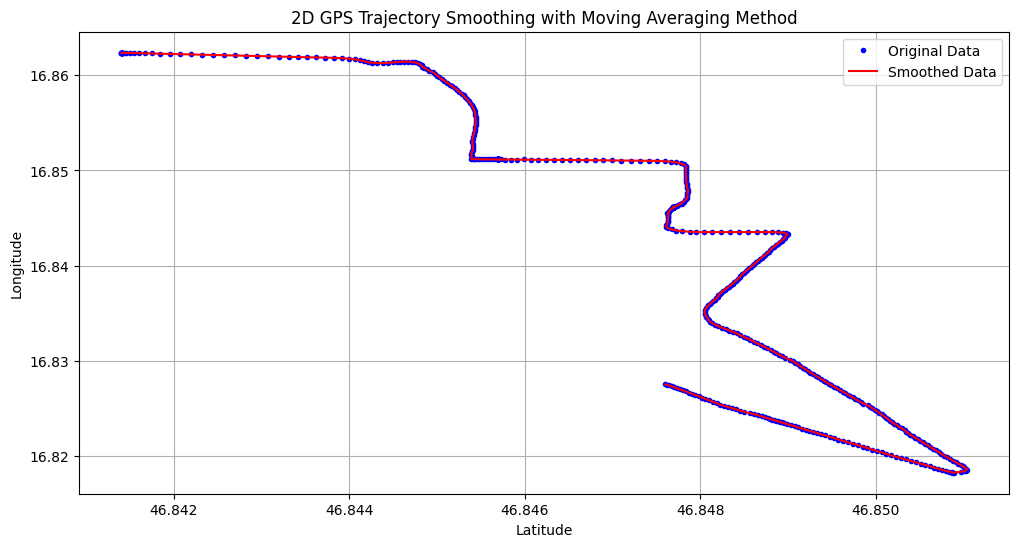

In [330]:
# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(loc['lat'], loc['lon'], 'b.', label='Original Data')
plt.plot(smoothed_df['lat'], smoothed_df['lon'], 'r-', label='Smoothed Data')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.legend()
plt.title('2D GPS Trajectory Smoothing with Moving Averaging Method')
plt.grid(True)
plt.show()

In [331]:
df.drop(labels=['lat','lon'], axis=1, inplace=True)
df = pd.concat([df, smoothed_df], axis=1)

df.head()

,time,seconds_elapsed,acc_z,acc_y,acc_x,gyr_z,gyr_y,gyr_x,speed,lat,lon
0,1728470326510681900,0.021682,-0.160272,-0.654907,1.204232,0.268744,0.022450,-0.001444,4.597376,46.847603,16.827526
1,1728470326520741600,0.031742,0.216822,-0.860115,1.101253,0.268238,0.003201,0.008170,4.615246,46.847603,16.827525
2,1728470326530802700,0.041803,0.221510,-0.980948,0.998023,0.268991,0.051419,-0.020873,4.633119,46.847604,16.827525
3,1728470326540863700,0.051864,0.609008,-0.838109,1.312107,0.261912,0.035823,-0.011840,4.650991,46.847604,16.827525
4,1728470326550923800,0.061924,-0.060423,-0.750109,1.020214,0.269707,0.037168,-0.012450,4.668862,46.847604,16.827524


### Spatial resampling

In [332]:
dDist = []
for j in np.arange(2,len(df)):
    d = abs(np.arccos(np.cos(np.deg2rad(90-df['lat'].loc[j-1])) * np.cos(np.deg2rad(90-df['lat'].loc[j])) + np.sin(np.deg2rad(90-df['lat'].loc[j-1])) * np.sin(np.deg2rad(90-df['lat'].loc[j]))) * np.cos(np.deg2rad(df['lon'].loc[j-1]-df['lon'].loc[j])) * 3958.76);
    dDist.append(d)
df_dDist = pd.DataFrame(dDist)
df_dDist.fillna(0,inplace=True) #remove the NaN values, introduced from the above calculation
df_dDist.isna().value_counts()

df_dDist[0].replace(0, 0.000001, inplace=True) #correct the count error

/var/folders/w_/802pn39d4f75d8__y1zs9yxm0000gn/T/ipykernel_1902/3827963625.py:3: RuntimeWarning:

invalid value encountered in arccos

/var/folders/w_/802pn39d4f75d8__y1zs9yxm0000gn/T/ipykernel_1902/3827963625.py:9: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





In [333]:
fs = 5

summed = np.cumsum(df_dDist.to_numpy())*2200   #calculated the total travelled distance by cumsum function
uniqe_indexes = np.unique(summed,return_index=True)
x = np.arange(0,max(summed),1/fs)

# Then we use again the interp function to convert the time domain to the spatial domain
df_spatial = pd.DataFrame()
for j in ['acc_z','acc_y','acc_x','gyr_z','gyr_y','gyr_x','lat','lon','speed','time','seconds_elapsed']:
    xp = df[j]
    df_spatial[j] = np.interp(x,uniqe_indexes[0],xp[uniqe_indexes[1]])


In [334]:
from scipy.interpolate import CubicSpline

In [335]:
#df_spatial_spline = pd.DataFrame()
#for j in ['acc_z','acc_y','acc_x','gyr_z','gyr_y','gyr_x','lat','lon','speed','time','seconds_elapsed']:
#    xp = df[j][:-2]
#    cs = CubicSpline(summed,xp)
#    df_spatial_spline[j] = cs(x)

### Normalization

In [336]:
from sklearn.preprocessing import normalize

In [337]:
df_normalized = pd.DataFrame(normalize(df_spatial[['acc_z', 'acc_y', 'acc_x', 'gyr_z', 'gyr_y', 'gyr_x']], norm='max', axis=0))
df_normalized.columns = ['acc_z', 'acc_y', 'acc_x', 'gyr_z', 'gyr_y', 'gyr_x']

df_normalized['lat'] = df_spatial['lat']
df_normalized['lon'] = df_spatial['lon']
df_normalized['speed'] = df_spatial['speed']
df_normalized['time'] = df_spatial['time']
df_normalized['seconds_elapsed'] = df_spatial['seconds_elapsed']

# Feature extraction

In [338]:
df_spatial.describe()

,acc_z,acc_y,acc_x,gyr_z,gyr_y,gyr_x,lat,lon,speed,time,seconds_elapsed
count,7399.000000,7399.000000,7399.000000,7399.000000,7.399000e+03,7399.000000,7399.000000,7399.000000,7399.000000,7.399000e+03,7399.000000
mean,0.053061,0.297633,0.068066,-0.010703,-4.192029e-04,0.000011,46.846585,16.845880,10.791750,1.728471e+18,321.608459
std,0.379802,0.522398,0.519100,0.093715,2.507058e-02,0.019757,0.002663,0.014503,3.224708,1.745735e+11,174.573488
min,-2.499479,-3.582440,-2.516677,-0.471915,-3.679351e-01,-0.129452,46.841405,16.818268,0.000000,1.728470e+18,0.021682
25%,-0.156707,-0.042565,-0.108365,-0.008808,-1.148062e-02,-0.010154,46.844089,16.833539,9.803778,1.728471e+18,173.779884
50%,0.052190,0.252128,0.035943,-0.000536,-6.839808e-07,-0.000403,46.847380,16.851017,11.389001,1.728471e+18,354.886652
75%,0.252074,0.623282,0.233230,0.006679,1.116345e-02,0.009124,46.848568,16.861625,12.869355,1.728471e+18,520.107905
max,3.608607,2.377132,3.057666,0.471087,3.954114e-01,0.174805,46.851035,16.862357,17.013258,1.728471e+18,558.184039


In [339]:
df_normalized.describe()

,acc_z,acc_y,acc_x,gyr_z,gyr_y,gyr_x,lat,lon,speed,time,seconds_elapsed
count,7399.000000,7399.000000,7399.000000,7399.000000,7399.000000,7399.000000,7399.000000,7399.000000,7399.000000,7.399000e+03,7399.000000
mean,0.014704,0.083081,0.022261,-0.022681,-0.001060,0.000065,46.846585,16.845880,10.791750,1.728471e+18,321.608459
std,0.105249,0.145822,0.169770,0.198585,0.063404,0.113025,0.002663,0.014503,3.224708,1.745735e+11,174.573488
min,-0.692644,-1.000000,-0.823071,-1.000000,-0.930512,-0.740550,46.841405,16.818268,0.000000,1.728470e+18,0.021682
25%,-0.043426,-0.011882,-0.035440,-0.018664,-0.029035,-0.058087,46.844089,16.833539,9.803778,1.728471e+18,173.779884
50%,0.014463,0.070379,0.011755,-0.001136,-0.000002,-0.002304,46.847380,16.851017,11.389001,1.728471e+18,354.886652
75%,0.069854,0.173982,0.076277,0.014153,0.028232,0.052197,46.848568,16.861625,12.869355,1.728471e+18,520.107905
max,1.000000,0.663551,1.000000,0.998245,1.000000,1.000000,46.851035,16.862357,17.013258,1.728471e+18,558.184039


### Spectrogram and Sum the Y axis

In [340]:
from scipy import signal

In [341]:
df_sum_spectrum = pd.DataFrame()
for var in ['acc_x', 'acc_y', 'acc_z', 'gyr_x', 'gyr_y', 'gyr_z']:
    f, t, Sxx = signal.spectrogram(df_normalized[var], 5, nperseg=50, noverlap=30) # here I use 5 Hz for fs    ### or nperseg=100 ???
    new_row = np.sum(Sxx, axis=0)
    df_sum_spectrum = pd.concat([df_sum_spectrum, pd.DataFrame([new_row]).T], ignore_index=True, axis=1)

df_sum_spectrum.columns = ['acc_x', 'acc_y', 'acc_z', 'gyr_x', 'gyr_y', 'gyr_z']

In [342]:
df_sum_spectrum

,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z
0,0.084883,0.565249,0.084413,0.135690,0.049029,0.107016
1,0.046019,0.254207,0.051902,0.180333,0.032312,0.002198
2,0.021619,0.124135,0.037246,0.165566,0.028558,0.002802
3,0.019804,0.157149,0.064433,0.251929,0.020369,0.002224
4,0.020201,0.139537,0.076019,0.288637,0.022120,0.001083
...,...,...,...,...,...,...
363,0.040703,0.050817,0.052090,0.019967,0.010553,0.017849
364,0.035322,0.021543,0.070025,0.022153,0.007358,0.017594
365,0.090585,0.012918,0.068301,0.029674,0.007319,0.673849
366,0.387836,0.052664,0.068179,0.033091,0.011811,0.372159


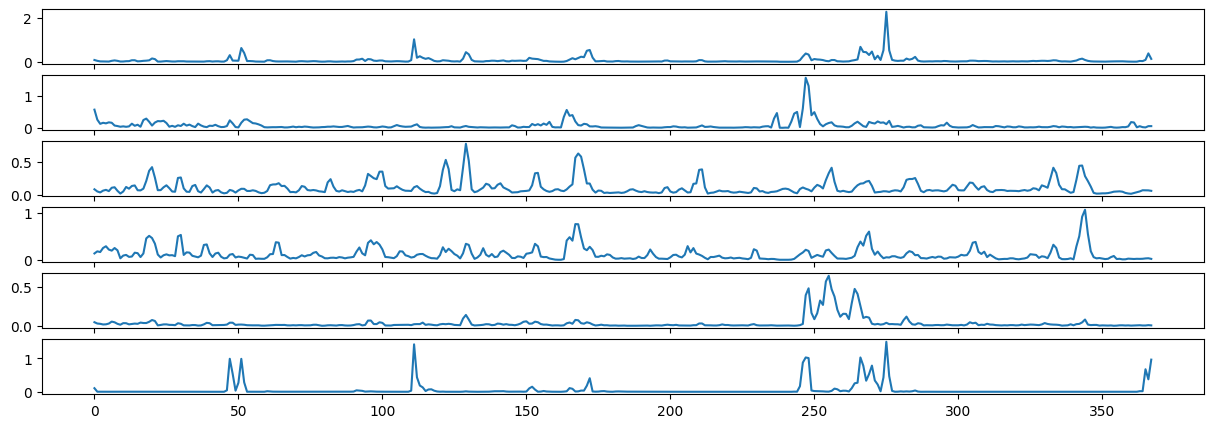

In [343]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(611)
plt.plot(df_sum_spectrum['acc_x'])
ax = fig.add_subplot(612)
plt.plot(df_sum_spectrum['acc_y'])
ax = fig.add_subplot(613)
plt.plot(df_sum_spectrum['acc_z'])
ax = fig.add_subplot(614)
plt.plot(df_sum_spectrum['gyr_x'])
ax = fig.add_subplot(615)
plt.plot(df_sum_spectrum['gyr_y'])
ax = fig.add_subplot(616)
plt.plot(df_sum_spectrum['gyr_z'])

In [344]:
# Interpolate the GPS data to fit for the spectrum data size

for j in ['lat','lon']:
    xp = df[j][:-2]
    cs = CubicSpline(summed,xp)
    df_sum_spectrum[j] = cs(t)

<Axes: xlabel='lon', ylabel='lat'>

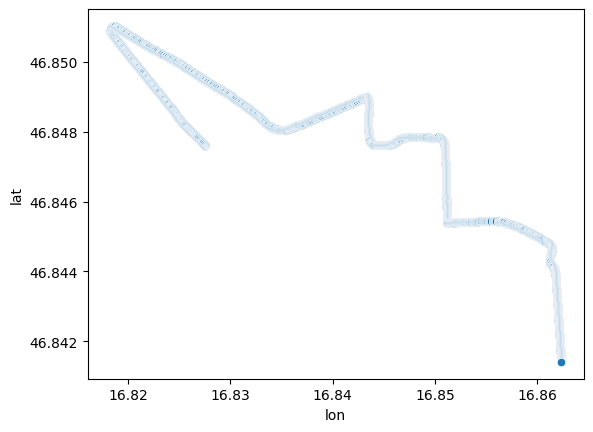

In [345]:
sns.scatterplot(df_spatial, x='lon',y='lat')

In [346]:
fig = px.scatter_mapbox(lat=df_sum_spectrum[df_sum_spectrum['acc_z'] < 0.2]['lat'], lon=df_sum_spectrum[df_sum_spectrum['acc_z'] < 0.2]['lon'], color= df_sum_spectrum[df_sum_spectrum['acc_z'] < 0.2]['acc_z'], zoom=10, width=500, height=500 , color_continuous_scale=px.colors.diverging.RdYlGn_r)
#fig.update_geos(scope='europe')
fig.update_geos(fitbounds="locations")
fig.update_layout(height=300, margin={"r":0,"t":0,"l":0,"b":0})
#fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(
    mapbox=dict(
    style="light", 
    accesstoken='pk.eyJ1Ijoicm9sYW5kbmFneSIsImEiOiJjbHRrZXptcWMweTJtMmlzNG40YjNmY3ozIn0.66tCRA-MiLLA-xAKcPiPlw',
    pitch=0,
    zoom=5
    )
)

fig.show()

### Aggressive maneuver detection

In [347]:
from scipy.signal import find_peaks

In [348]:
# Aggressive maneuver are represented by the acc_x and the gyr_z variables
    # See the above correlation map
    # And the sensor orientation
    
df_sum_spectrum[['acc_x','gyr_z']].describe()

,acc_x,gyr_z
count,368.000000,368.000000
mean,0.071588,0.055120
std,0.161109,0.193971
min,0.003603,0.000164
25%,0.017151,0.000603
50%,0.026348,0.001206
75%,0.057162,0.007400
max,2.291731,1.494284


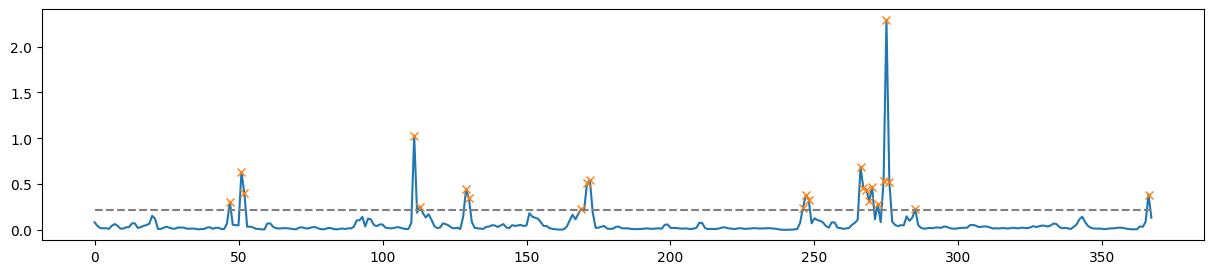

In [349]:
# Find aggressive turnings in acc_x
#peaks_accx, _ = find_peaks(df_sum_spectrum['acc_x'], height=0.22)
peaks_accx = df_sum_spectrum[df_sum_spectrum['acc_x'] > 0.22].index

plt.figure(figsize=(15,3))
plt.plot(df_sum_spectrum['acc_x'])
plt.plot(peaks_accx, df_sum_spectrum['acc_x'][peaks_accx], "x")
plt.plot(np.zeros_like(df_sum_spectrum['acc_x'])+0.22, "--", color="gray")
plt.show()

In [350]:
fig = px.scatter_mapbox(lat=df_sum_spectrum['lat'][peaks_accx], lon=df_sum_spectrum['lon'][peaks_accx], zoom=10, width=500, height=500 , color_continuous_scale=px.colors.diverging.RdYlGn_r)
#fig.update_geos(scope='europe')
fig.update_geos(fitbounds="locations")
fig.update_layout(height=300, margin={"r":0,"t":0,"l":0,"b":0})
#fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(
    mapbox=dict(
    style="light", 
    accesstoken='pk.eyJ1Ijoicm9sYW5kbmFneSIsImEiOiJjbHRrZXptcWMweTJtMmlzNG40YjNmY3ozIn0.66tCRA-MiLLA-xAKcPiPlw',
    pitch=0,
    zoom=5
    )
)

fig.show()

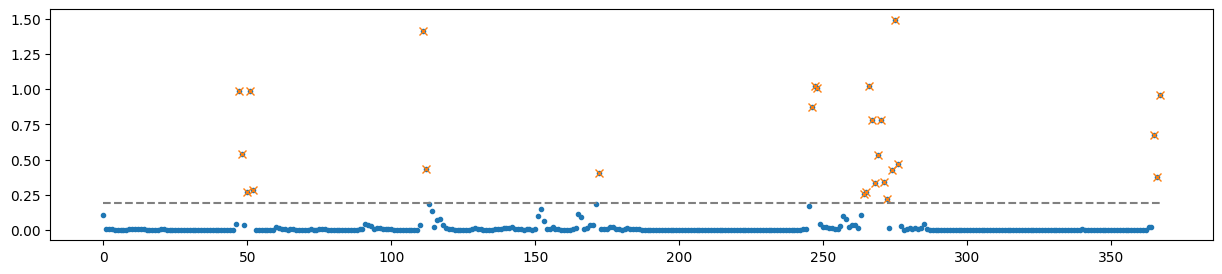

In [351]:
# Find aggressive turnings in gyr_z

#peaks_gyrz, _ = find_peaks(df_sum_spectrum['gyr_z'], height = np.std(df_sum_spectrum['gyr_z']), distance=1)
peaks_gyrz = df_sum_spectrum[df_sum_spectrum['gyr_z'] > np.std(df_sum_spectrum['gyr_z'])].index

plt.figure(figsize=(15,3))
plt.plot(df_sum_spectrum['gyr_z'],'.')
plt.plot(peaks_gyrz, df_sum_spectrum['gyr_z'][peaks_gyrz], "x")
plt.plot(np.zeros_like(df_sum_spectrum['gyr_z']) + np.std(df_sum_spectrum['gyr_z']), "--", color="gray")
plt.show()

In [352]:
fig = px.scatter_mapbox(lat=df_sum_spectrum['lat'][peaks_gyrz], lon=df_sum_spectrum['lon'][peaks_gyrz], zoom=10, width=500, height=500 , color_continuous_scale=px.colors.diverging.RdYlGn_r)
#fig.update_geos(scope='europe')
fig.update_geos(fitbounds="locations")
fig.update_layout(height=300, margin={"r":0,"t":0,"l":0,"b":0})
#fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(
    mapbox=dict(
    style="light", 
    accesstoken='pk.eyJ1Ijoicm9sYW5kbmFneSIsImEiOiJjbHRrZXptcWMweTJtMmlzNG40YjNmY3ozIn0.66tCRA-MiLLA-xAKcPiPlw',
    pitch=0,
    zoom=5
    )
)

fig.show()

In [353]:
peaks = pd.concat([pd.DataFrame(peaks_accx), pd.DataFrame(peaks_gyrz)], join="outer", ignore_index=True).drop_duplicates()[0]
peaks # Location indexes of aggressive turnings

0      47
1      51
2      52
3     111
4     113
5     129
6     130
7     169
8     171
9     172
10    246
11    247
12    248
13    266
14    267
15    268
16    269
17    270
18    272
19    274
20    275
21    276
22    285
23    366
25     48
26     50
30    112
35    264
36    265
42    271
47    365
49    367
Name: 0, dtype: int64

In [354]:
fig = px.scatter_mapbox(lat=df_sum_spectrum['lat'][peaks], lon=df_sum_spectrum['lon'][peaks], zoom=10, width=500, height=500 , color_continuous_scale=px.colors.diverging.RdYlGn_r)
#fig.update_geos(scope='europe')
fig.update_geos(fitbounds="locations")
fig.update_layout(height=300, margin={"r":0,"t":0,"l":0,"b":0})
#fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(
    mapbox=dict(
    style="light", 
    accesstoken='pk.eyJ1Ijoicm9sYW5kbmFneSIsImEiOiJjbHRrZXptcWMweTJtMmlzNG40YjNmY3ozIn0.66tCRA-MiLLA-xAKcPiPlw',
    pitch=0,
    zoom=5
    )
)

fig.show()

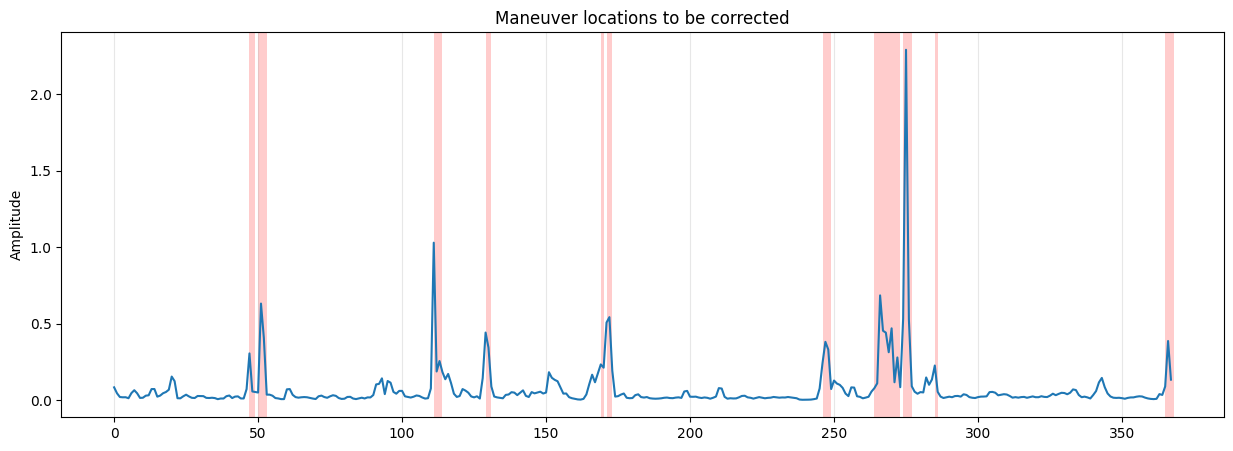

In [355]:
ax = df_sum_spectrum['acc_x'].plot(figsize=(15, 5), use_index=False, ylabel='Amplitude')
ax.grid(axis='x', alpha=0.3)
plt.title('Maneuver locations to be corrected')

# Highlight aggressive turning maneuvers
for peak in zip(peaks):
    ax.axvspan(peak[0], peak[0]+1, facecolor='red', alpha=.2)

#### Correction

In [356]:
df_sum_spectrum_corrected = df_sum_spectrum.copy()

In [357]:
df_sum_spectrum_corrected['acc_x'][peaks] = df_sum_spectrum['acc_x'].median()

/var/folders/w_/802pn39d4f75d8__y1zs9yxm0000gn/T/ipykernel_1902/746328853.py:1: FutureWarning:

ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




In [358]:
df_sum_spectrum_corrected['gyr_z'].loc[peaks] = df_sum_spectrum['gyr_z'].median()

/var/folders/w_/802pn39d4f75d8__y1zs9yxm0000gn/T/ipykernel_1902/475576752.py:1: FutureWarning:

ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




## Correct lognormal distribution and normalization

In [359]:
df_sum_spectrum_corrected.columns

Index(['acc_x', 'acc_y', 'acc_z', 'gyr_x', 'gyr_y', 'gyr_z', 'lat', 'lon'], dtype='object')

<Axes: ylabel='Frequency'>

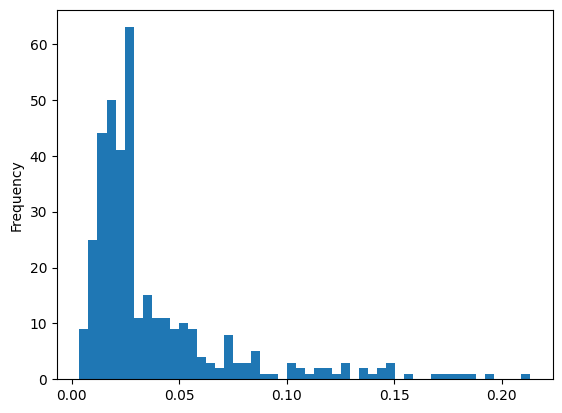

In [360]:
# skewed data, lognormal distribution

df_sum_spectrum_corrected['acc_x'].plot(kind='hist', bins=50)

- with PowerTransformer

In [361]:
from sklearn.preprocessing import MinMaxScaler

In [362]:
scaler = MinMaxScaler(feature_range=(0.0000000001,1))
df_scaled = scaler.fit_transform(df_sum_spectrum_corrected[['acc_x', 'acc_y', 'acc_z', 'gyr_x', 'gyr_y', 'gyr_z']])

In [363]:
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer(method='box-cox', standardize=False)
df_rescaled = pt.fit_transform(df_scaled)
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PowerTransformer.html#sklearn.preprocessing.PowerTransformer
# https://scikit-learn.org/stable/modules/preprocessing.html

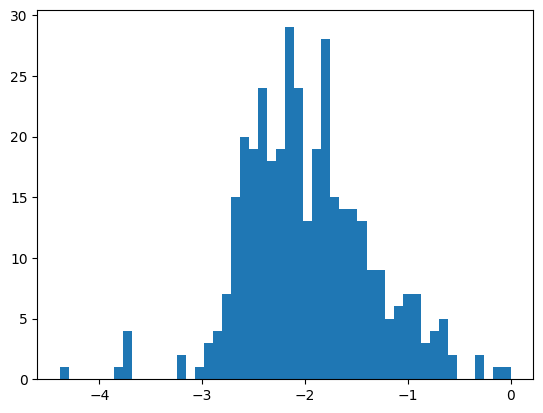

In [364]:
plt.hist(df_rescaled[:,3], bins=50);  #acc_z axis

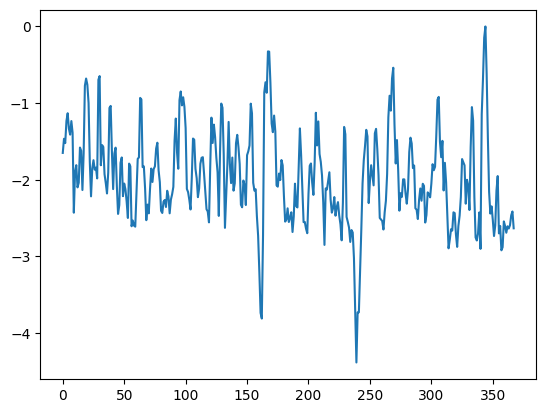

In [365]:
plt.plot(df_rescaled[:,3])

- with standard deviation based outlier removal

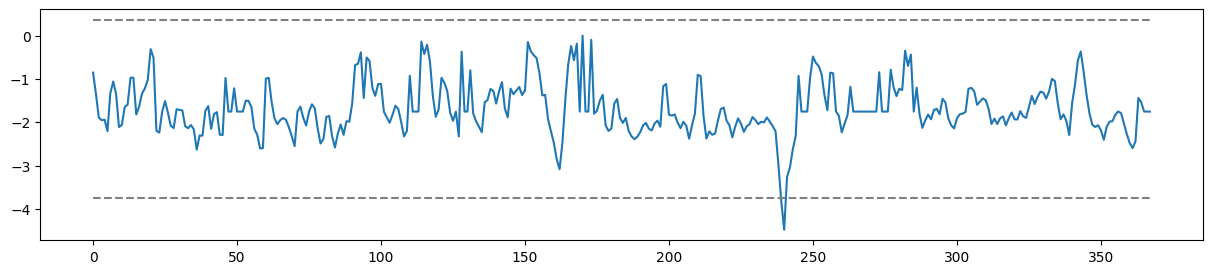

In [366]:
plt.figure(figsize=(15,3))
plt.plot(df_rescaled[:,0])
plt.plot((np.zeros_like(df_rescaled[:,0])+df_rescaled[:,0].mean()) + df_rescaled[:,0].std()*3.5, "--", color="gray")
plt.plot((np.zeros_like(df_rescaled[:,0])+df_rescaled[:,0].mean()) - df_rescaled[:,0].std()*3.5, "--", color="gray")
plt.show()

In [367]:
df_outliers_removed = pd.DataFrame(df_rescaled).copy()
for vars in df_outliers_removed:
    df_outliers_removed[vars][df_outliers_removed[vars] > (df_outliers_removed[vars].mean() + df_outliers_removed[vars].std()*3.5)] = (df_outliers_removed[vars].mean() + df_outliers_removed[vars].std()*3.5)
    df_outliers_removed[vars][df_outliers_removed[vars] < (df_outliers_removed[vars].mean() - df_outliers_removed[vars].std()*3.5)] = (df_outliers_removed[vars].mean() - df_outliers_removed[vars].std()*3.5)

/var/folders/w_/802pn39d4f75d8__y1zs9yxm0000gn/T/ipykernel_1902/3484797227.py:3: FutureWarning:

ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


/var/folders/w_/802pn39d4f75d8__y1zs9yxm0000gn/T/ipykernel_1902/3484797227.py:4: FutureWarning:

ChainedAssignment

In [368]:
fig = px.scatter_mapbox(lat=df_sum_spectrum['lat'], lon=df_sum_spectrum['lon'], color = df_outliers_removed[3], zoom=10, width=500, height=500 , color_continuous_scale=px.colors.diverging.RdYlGn_r)
#fig.update_geos(scope='europe')
fig.update_geos(fitbounds="locations")
fig.update_layout(height=300, margin={"r":0,"t":0,"l":0,"b":0})
#fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(
    mapbox=dict(
    style="light", 
    accesstoken='pk.eyJ1Ijoicm9sYW5kbmFneSIsImEiOiJjbHRrZXptcWMweTJtMmlzNG40YjNmY3ozIn0.66tCRA-MiLLA-xAKcPiPlw',
    pitch=0,
    zoom=5
    )
)

fig.show()

# Segmentation

In [369]:
import ruptures as rpt

In [370]:
# detection with https://centre-borelli.github.io/ruptures-docs/code-reference/detection/pelt-reference/ 

#algo = rpt.Dynp(model="l2").fit(df_outliers_removed[0].to_numpy())
#result = algo.predict(n_bkps=40)

algo = rpt.Pelt().fit(df_outliers_removed[2].to_numpy())
result = algo.predict(1) #original pen=1
result[:5]

[10, 40, 60, 95, 100]

<Axes: >

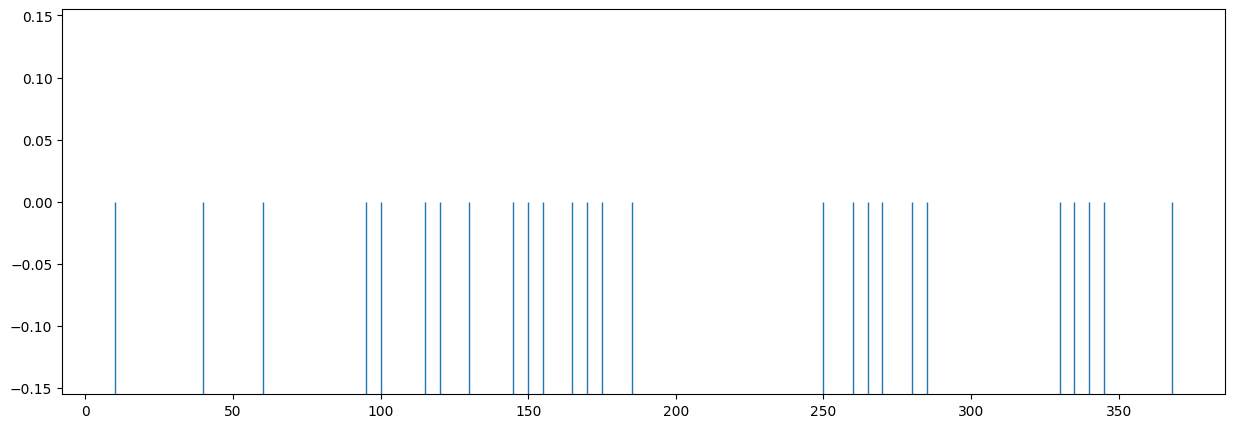

In [371]:
# Plot the section boudaries
plt.figure(figsize=(15,5))
sns.rugplot(result, height=0.5)

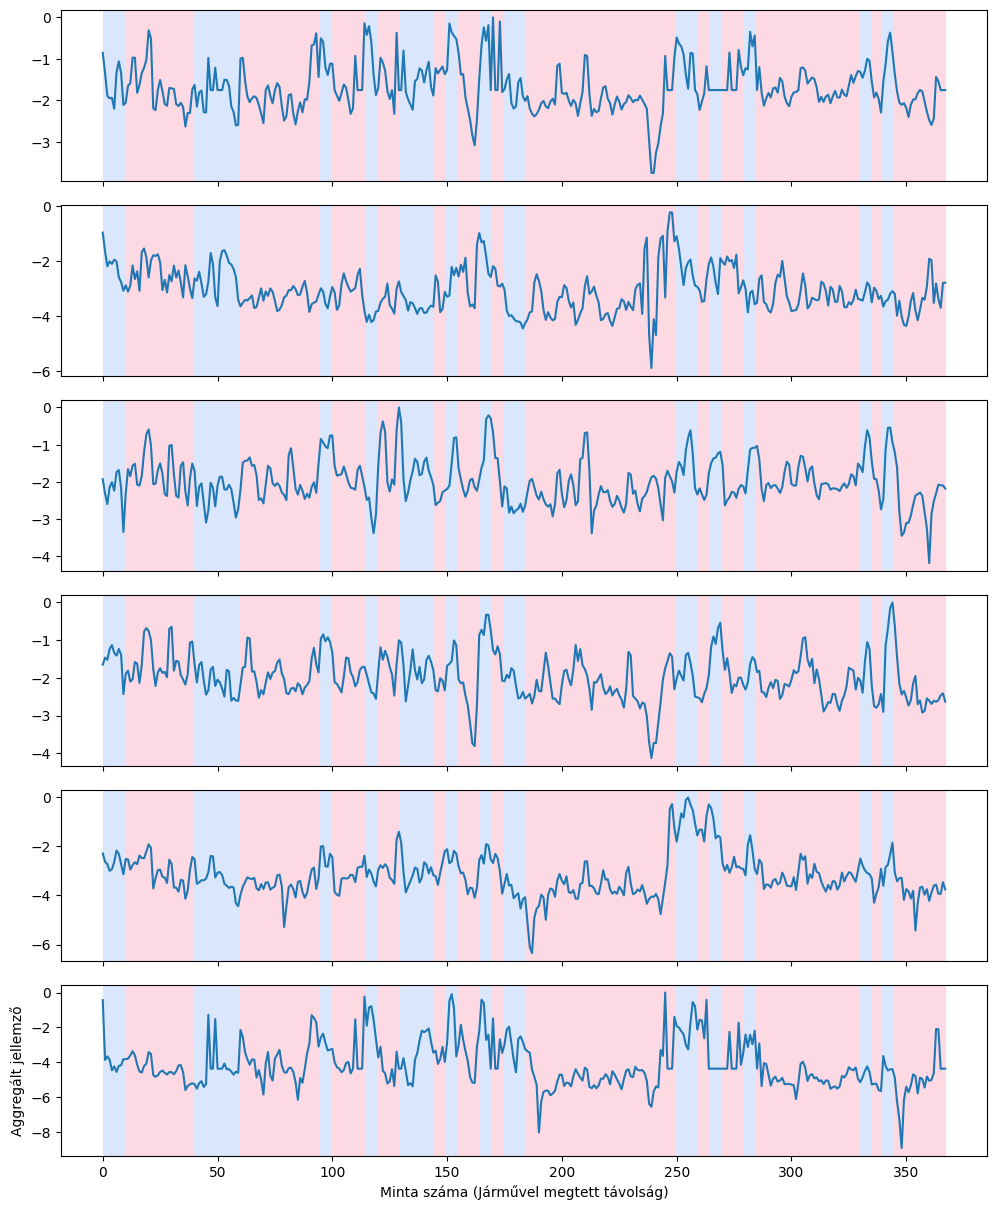

In [372]:
# display segmentation
rpt.display(df_outliers_removed.to_numpy(), result)
plt.xlabel('Minta száma (Járművel megtett távolság)')
plt.ylabel('Aggregált jellemző')
plt.show()

In [373]:
from scipy import stats

def calculate_mean_vector(df, breakpoints): #mean
    vector = np.zeros(len(df))
    for i in range(len(breakpoints) - 1):
        start = breakpoints[i]
        end = breakpoints[i + 1]
        segment = df.iloc[start:end]
        value = segment.mean()
        vector[start:end] = value
    return vector

def calculate_var_vector(df, breakpoints): #variance
    vector = np.zeros(len(df))
    for i in range(len(breakpoints) - 1):
        start = breakpoints[i]
        end = breakpoints[i + 1]
        segment = df.iloc[start:end]
        value = segment.var()
        vector[start:end] = value
    return vector

def calculate_std_vector(df, breakpoints): #std
    vector = np.zeros(len(df))
    for i in range(len(breakpoints) - 1):
        start = breakpoints[i]
        end = breakpoints[i + 1]
        segment = df.iloc[start:end]
        value = segment.std()
        vector[start:end] = value
    return vector

def calculate_median_vector(df, breakpoints): #median
    vector = np.zeros(len(df))
    for i in range(len(breakpoints) - 1):
        start = breakpoints[i]
        end = breakpoints[i + 1]
        segment = df.iloc[start:end]
        value = segment.median()
        vector[start:end] = value
    return vector

#rms
#rms = np.sqrt(np.mean(y**2))
def calculate_rms_vector(df, breakpoints): #median
    vector = np.zeros(len(df))
    for i in range(len(breakpoints) - 1):
        start = breakpoints[i]
        end = breakpoints[i + 1]
        segment = df.iloc[start:end]
        value = np.sqrt(np.mean(segment**2))
        vector[start:end] = value
    return vector


def calculate_entropy_vector(df, breakpoints): #entropy
    vector = np.zeros(len(df))
    for i in range(len(breakpoints) - 1):
        start = breakpoints[i]
        end = breakpoints[i + 1]
        segment = df.iloc[start:end]
        value = stats.entropy(segment)
        vector[start:end] = value
    return vector

def calculate_kurtosis_vector(df, breakpoints): #kurtosis
    vector = np.zeros(len(df))
    for i in range(len(breakpoints) - 1):
        start = breakpoints[i]
        end = breakpoints[i + 1]
        segment = df.iloc[start:end]
        value = stats.kurtosis(segment)
        vector[start:end] = value
    return vector


def calculate_len_vector(df, breakpoints): #length
    vector = np.zeros(len(df))
    for i in range(len(breakpoints) - 1):
        start = breakpoints[i]
        end = breakpoints[i + 1]
        segment = df.iloc[start:end]
        value = len(segment)
        vector[start:end] = value
    return vector

def calculate_spikiness_vector(df, breakpoints): #spikiness
    vector = np.zeros(len(df))
    for i in range(len(breakpoints) - 1):
        start = breakpoints[i]
        end = breakpoints[i + 1]
        segment = df.iloc[start:end]
        value = np.var(np.diff(segment))
        vector[start:end] = value
    return vector

import statsmodels.api as sm

def calculate_stability_vector(df, breakpoints): #spikiness
    vector = np.zeros(len(df))
    for i in range(len(breakpoints) - 1):
        start = breakpoints[i]
        end = breakpoints[i + 1]
        segment = df.iloc[start:end]
        value = np.median(sm.tsa.acf(segment, nlags=10))
        vector[start:end] = value
    return vector

In [374]:
df_outliers_removed.columns = ['acc_x', 'acc_y', 'acc_z', 'gyr_x', 'gyr_y', 'gyr_z']

In [375]:
df_outliers_removed

,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z
0,-0.855033,-0.952689,-1.926546,-1.649121,-2.292032,-0.434267
1,-1.345835,-1.624961,-2.313032,-1.464312,-2.627460,-3.870931
2,-1.892944,-2.175860,-2.597202,-1.521060,-2.726608,-3.669667
3,-1.953816,-1.999632,-2.139084,-1.231496,-2.999931,-3.861395
4,-1.940079,-2.089048,-2.008673,-1.131668,-2.932765,-4.467923
...,...,...,...,...,...,...
363,-1.438394,-2.804120,-2.310078,-2.635356,-3.565191,-2.095702
364,-1.543280,-3.362703,-2.073273,-2.591444,-3.930461,-2.108418
365,-1.754155,-3.685692,-2.092945,-2.462884,-3.936399,-4.375278
366,-1.754155,-2.780058,-2.094355,-2.412943,-3.462439,-4.375278


In [376]:
# Generate new values for feature space
"""
df_features = df_outliers_removed.copy()
df_features['mean'] = calculate_mean_vector(df_outliers_removed[2], result)
df_features['std'] = calculate_std_vector(df_outliers_removed[2], result)
df_features['var'] = calculate_var_vector(df_outliers_removed[2], result)
df_features['median'] = calculate_median_vector(df_outliers_removed[2], result)
df_features['rms'] = calculate_rms_vector(df_outliers_removed[2], result)
df_features['kurtosis'] = calculate_kurtosis_vector(df_outliers_removed[2], result)
df_features['length'] = calculate_len_vector(df_outliers_removed[2], result)
df_features['spikiness'] = calculate_spikiness_vector(df_outliers_removed[2], result)
df_features['stability'] = calculate_stability_vector(df_outliers_removed[2], result)
"""

"\ndf_features = df_outliers_removed.copy()\ndf_features['mean'] = calculate_mean_vector(df_outliers_removed[2], result)\ndf_features['std'] = calculate_std_vector(df_outliers_removed[2], result)\ndf_features['var'] = calculate_var_vector(df_outliers_removed[2], result)\ndf_features['median'] = calculate_median_vector(df_outliers_removed[2], result)\ndf_features['rms'] = calculate_rms_vector(df_outliers_removed[2], result)\ndf_features['kurtosis'] = calculate_kurtosis_vector(df_outliers_removed[2], result)\ndf_features['length'] = calculate_len_vector(df_outliers_removed[2], result)\ndf_features['spikiness'] = calculate_spikiness_vector(df_outliers_removed[2], result)\ndf_features['stability'] = calculate_stability_vector(df_outliers_removed[2], result)\n"

In [377]:
# Calculate std and median features for all variables, as these features were the most representative of the information content 

df_features = pd.DataFrame()
for i in ['acc_x', 'acc_y', 'acc_z', 'gyr_x', 'gyr_y', 'gyr_z']:
    df_features['std_' + i] = calculate_std_vector(df_outliers_removed[i], result)
    df_features['median_' + i] = calculate_median_vector(df_outliers_removed[i], result)
df_features = df_features.iloc[10:]

## PCA

In [378]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(df_features)
df_pca = pd.DataFrame(pca.transform(df_features))

[0.56823932 0.75182246 0.83964581 0.89544755 0.93495225 0.95752327
 0.97358376 0.9840663  0.99128413 0.99660498 0.99885443 1.        ]


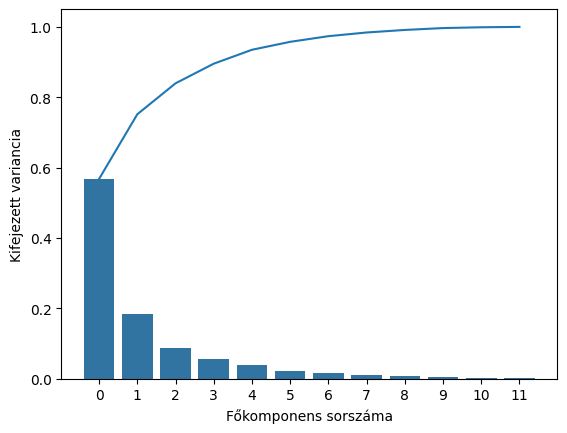

In [379]:
sns.barplot(x=np.arange(0,len(pca.explained_variance_ratio_)),y=pca.explained_variance_ratio_)
plt.plot(pca.explained_variance_ratio_.cumsum())
plt.xlabel('Főkomponens sorszáma')
plt.ylabel('Kifejezett variancia')

print(pca.explained_variance_ratio_.cumsum())

In [380]:
# Reduce the number of dimensions to 4

df_pca.drop(labels=np.linspace(4,11,8), axis=1, inplace=True)

(-2.0, 4.0)

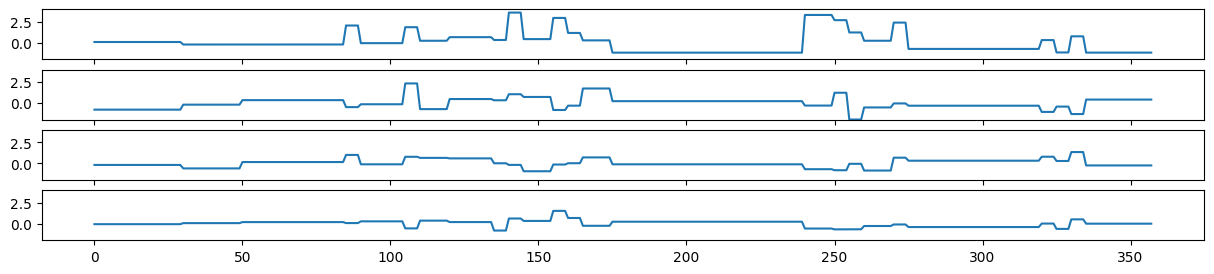

In [381]:
fig = plt.figure(figsize=(15,3))
ax = fig.add_subplot(411)
plt.plot(df_pca[0])
plt.ylim(bottom=-2, top=4)
ax = fig.add_subplot(412)
plt.plot(df_pca[1])
plt.ylim(bottom=-2, top=4)
ax = fig.add_subplot(413)
plt.plot(df_pca[2])
plt.ylim(bottom=-2, top=4)
ax = fig.add_subplot(414)
plt.plot(df_pca[3])
plt.ylim(bottom=-2, top=4)

In [382]:
df_pca

,0,1,2,3
0,0.090413,-0.792141,-0.197478,-0.076195
1,0.090413,-0.792141,-0.197478,-0.076195
2,0.090413,-0.792141,-0.197478,-0.076195
3,0.090413,-0.792141,-0.197478,-0.076195
4,0.090413,-0.792141,-0.197478,-0.076195
...,...,...,...,...
353,-1.177787,0.411164,-0.258064,-0.016708
354,-1.177787,0.411164,-0.258064,-0.016708
355,-1.177787,0.411164,-0.258064,-0.016708
356,-1.177787,0.411164,-0.258064,-0.016708


#### Export the data

In [383]:
to_export = pd.DataFrame([df_sum_spectrum['lat'].iloc[10:], df_sum_spectrum['lon'].iloc[10:]]).T
to_export = pd.concat([to_export.reset_index(drop=True), df_features.reset_index(drop=True)], axis=1)
to_export

,lat,lon,std_acc_x,median_acc_x,std_acc_y,median_acc_y,std_acc_z,median_acc_z,std_gyr_x,median_gyr_x,std_gyr_y,median_gyr_y,std_gyr_z,median_gyr_z
0,46.848406,16.824902,0.54474,-1.746592,0.525202,-2.559717,0.526531,-1.794256,0.502961,-1.786367,0.579080,-2.950784,0.578218,-4.549031
1,46.848481,16.824702,0.54474,-1.746592,0.525202,-2.559717,0.526531,-1.794256,0.502961,-1.786367,0.579080,-2.950784,0.578218,-4.549031
2,46.848530,16.824604,0.54474,-1.746592,0.525202,-2.559717,0.526531,-1.794256,0.502961,-1.786367,0.579080,-2.950784,0.578218,-4.549031
3,46.848593,16.824464,0.54474,-1.746592,0.525202,-2.559717,0.526531,-1.794256,0.502961,-1.786367,0.579080,-2.950784,0.578218,-4.549031
4,46.848669,16.824259,0.54474,-1.746592,0.525202,-2.559717,0.526531,-1.794256,0.502961,-1.786367,0.579080,-2.950784,0.578218,-4.549031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
353,46.841560,16.862324,0.32803,-1.985480,0.658072,-3.433031,0.647422,-2.520573,0.502311,-2.591444,0.469498,-3.755175,1.404149,-4.970507
354,46.841525,16.862336,0.32803,-1.985480,0.658072,-3.433031,0.647422,-2.520573,0.502311,-2.591444,0.469498,-3.755175,1.404149,-4.970507
355,46.841481,16.862350,0.32803,-1.985480,0.658072,-3.433031,0.647422,-2.520573,0.502311,-2.591444,0.469498,-3.755175,1.404149,-4.970507
356,46.841430,16.862355,0.32803,-1.985480,0.658072,-3.433031,0.647422,-2.520573,0.502311,-2.591444,0.469498,-3.755175,1.404149,-4.970507


In [384]:
to_export.to_csv('./../../Data_phone/final/processed_features_data/'+file_name+'.csv', index=False)